In [2]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import scipy.sparse as sparse
import contextily as cx

In [3]:
data = geopandas.read_file("https://opendata.arcgis.com/datasets/5512df2ff41e4941bacf868053dbfba9_0.geojson")

   HMGNS_LNK_ID                                           geometry
0          2006  LINESTRING (145.83723 -37.53280, 145.83760 -37...
1          8786  LINESTRING (145.37230 -37.60790, 145.37230 -37...
4          3475  LINESTRING (145.17170 -38.01166, 145.17087 -38...
5          7954  LINESTRING (144.82830 -37.71610, 144.82840 -37...
7          7398  LINESTRING (144.76926 -37.81222, 144.76919 -37...


<AxesSubplot:>

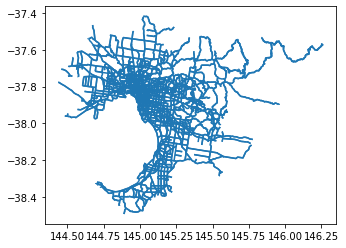

In [4]:
metro = data["RGN_LONG_NM"].isin(["METROPOLITAN NORTH WEST REGION", "METROPOLITAN SOUTH EAST REGION"])
metro_data = data[metro]
sdf = metro_data[['HMGNS_LNK_ID', 'geometry']]
print(sdf.head())
sdf.plot()

In [5]:
hourly = pd.read_csv('TYPICAL_HOURLY_VOLUME_DATA.csv')
hourly_dropped = hourly.drop(['HMGNS_FLOW_ID', 'HMGNS_LNK_DESC', 'FLOW', 'COUNT_TYPE', 'PERIOD_TYPE'], axis=1)
print(hourly_dropped.head())

   HMGNS_LNK_ID  DOW  0:00  1:00  2:00  3:00  4:00  5:00  6:00  7:00  ...  \
0          7581    1  1314   835   636   562   531   701  1416  2544  ...   
1          7581    1  1189   597   495   391   526  1173  3089  5196  ...   
2          7581    1   836   461   316   299   442  1080  2999  5226  ...   
3          7581    2  1344   742   483   423   414   722  2108  4219  ...   
4          7581    2  1178   620   421   359   422   902  2520  4594  ...   

   14:00  15:00  16:00  17:00  18:00  19:00  20:00  21:00  22:00  23:00  
0   5030   5891   6279   6708   5039   3358   2853   2496   2205   1804  
1   5874   7934   8342   8761   7501   4594   3063   2663   2347   1803  
2   5951   7453   7955   8152   6779   4002   2834   2569   2116   1415  
3   5360   6594   7558   8058   7209   4988   3619   3071   2671   2587  
4   5389   6880   7325   7902   6707   4305   3059   2744   2477   2048  

[5 rows x 26 columns]


In [6]:
hourly_dropped = hourly_dropped.rename(columns={"0:00": "0", "1:00": "1", "2:00": "2", "3:00": "3", "4:00": "4", "5:00": "5", "6:00": "6", "7:00": "7", "8:00": "8", "9:00": "9", "10:00": "10", "11:00": "11", "12:00": "12", "13:00": "13", "14:00": "14", "15:00": "15", "16:00": "16", "17:00": "17", "18:00": "18", "19:00": "19", "20:00": "20", "21:00": "21", "22:00": "22", "23:00": "23"}, errors="raise")
print(hourly_dropped.head())

   HMGNS_LNK_ID  DOW     0    1    2    3    4     5     6     7  ...    14  \
0          7581    1  1314  835  636  562  531   701  1416  2544  ...  5030   
1          7581    1  1189  597  495  391  526  1173  3089  5196  ...  5874   
2          7581    1   836  461  316  299  442  1080  2999  5226  ...  5951   
3          7581    2  1344  742  483  423  414   722  2108  4219  ...  5360   
4          7581    2  1178  620  421  359  422   902  2520  4594  ...  5389   

     15    16    17    18    19    20    21    22    23  
0  5891  6279  6708  5039  3358  2853  2496  2205  1804  
1  7934  8342  8761  7501  4594  3063  2663  2347  1803  
2  7453  7955  8152  6779  4002  2834  2569  2116  1415  
3  6594  7558  8058  7209  4988  3619  3071  2671  2587  
4  6880  7325  7902  6707  4305  3059  2744  2477  2048  

[5 rows x 26 columns]


In [7]:
hourly_long = hourly_dropped.melt(id_vars=['HMGNS_LNK_ID','DOW'], value_vars=hourly_dropped.iloc[:,2:27], var_name='Hour', value_name='Value')
hourly_long['Hour'] = pd.to_numeric(hourly_long['Hour'])
print(hourly_long.head(10))

   HMGNS_LNK_ID  DOW  Hour  Value
0          7581    1     0   1314
1          7581    1     0   1189
2          7581    1     0    836
3          7581    2     0   1344
4          7581    2     0   1178
5          7581    2     0    915
6          7581    3     0    854
7          7581    3     0   1140
8          7581    3     0    905
9          7581    4     0    882


In [8]:
grouped_hourly = hourly_long.groupby('DOW')
print(grouped_hourly.head(10))

    HMGNS_LNK_ID  DOW  Hour  Value
0           7581    1     0   1314
1           7581    1     0   1189
2           7581    1     0    836
3           7581    2     0   1344
4           7581    2     0   1178
..           ...  ...   ...    ...
69          8726    3     0    941
72          8726    4     0    972
75          8726    5     0   1255
78          8726    6     0   2228
81          8726    7     0   2694

[70 rows x 4 columns]


In [9]:
grouped_multiple = hourly_long.groupby(['DOW', 'HMGNS_LNK_ID', 'Hour']).agg({'Value': 'mean'})
grouped_multiple.columns = ['Average Value']
grouped_multiple = grouped_multiple.reset_index()
sorted_df = grouped_multiple.sort_values(["HMGNS_LNK_ID", "DOW", "Hour"], ascending = (True, True, True))
print(sorted_df.head(25))

        DOW  HMGNS_LNK_ID  Hour  Average Value
0         1             2     0     909.833333
1         1             2     1     531.166667
2         1             2     2     424.166667
3         1             2     3     422.666667
4         1             2     4     739.666667
5         1             2     5    2027.000000
6         1             2     6    4628.833333
7         1             2     7    5888.166667
8         1             2     8    6070.000000
9         1             2     9    5164.333333
10        1             2    10    4920.166667
11        1             2    11    5074.666667
12        1             2    12    5186.166667
13        1             2    13    5173.500000
14        1             2    14    5574.666667
15        1             2    15    6509.000000
16        1             2    16    6948.000000
17        1             2    17    7482.666667
18        1             2    18    6003.666667
19        1             2    19    3744.500000
20        1  

In [13]:
sorted_df['Normalised Value']=(sorted_df['Average Value']-sorted_df['Average Value'].min())/(sorted_df['Average Value'].max()-sorted_df['Average Value'].min())
sorted_df['Normalised Value']=4*sorted_df['Normalised Value']

In [14]:
df = sdf.merge(sorted_df, on="HMGNS_LNK_ID", how="right")

In [32]:
smol_df = df.iloc[0:100000, :]
print(smol_df.head(26))

    HMGNS_LNK_ID                                           geometry  DOW  \
0              2  LINESTRING (145.13947 -37.89366, 145.14087 -37...    1   
1              2  LINESTRING (145.14411 -37.89482, 145.14386 -37...    1   
2              2  LINESTRING (145.13947 -37.89366, 145.14087 -37...    1   
3              2  LINESTRING (145.14411 -37.89482, 145.14386 -37...    1   
4              2  LINESTRING (145.13947 -37.89366, 145.14087 -37...    1   
5              2  LINESTRING (145.14411 -37.89482, 145.14386 -37...    1   
6              2  LINESTRING (145.13947 -37.89366, 145.14087 -37...    1   
7              2  LINESTRING (145.14411 -37.89482, 145.14386 -37...    1   
8              2  LINESTRING (145.13947 -37.89366, 145.14087 -37...    1   
9              2  LINESTRING (145.14411 -37.89482, 145.14386 -37...    1   
10             2  LINESTRING (145.13947 -37.89366, 145.14087 -37...    1   
11             2  LINESTRING (145.14411 -37.89482, 145.14386 -37...    1   
12          

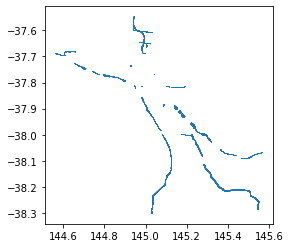

<Figure size 1382.4x777.6 with 0 Axes>

In [56]:
fig, ax = plt.subplots()
smol_df.plot(ax=ax, linewidth=smol_df['Normalised Value'])
plt.axis
fig = plt.figure(figsize=(19.2, 10.8))
plt.show()

In [50]:
for dow in df['DOW']:
    fig, ax = plt.subplots()
    day_df = df[df['DOW']==dow]

    for hour in df['Hour']:
        day_hour_df = day_df[day_df['Hour']==hour]
        day_hour_df.plot(ax=ax, linewidth=day_hour_df['Normalised Value'])
        plt.axis('off')
        plt.savefig("day-{}_hour-{}.png".format(dow, hour), dpi = 200)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fcc5c23af70> (for post_execute):


KeyboardInterrupt: 